## **Problem Statement**

In the fast-evolving landscape of the entertainment industry, it is important to gauge audience sentiments towards movie releases. Understanding the sentiments expressed in movie reviews is crucial for shaping marketing strategies, refining content creation, and ultimately enhancing the overall viewer experience. However, manually analyzing an extensive volume of reviews is time-consuming and may not capture nuanced sentiments at scale. To address this, we aim to develop an ML-based sentiment analyzer that automatically evaluates movie reviews, providing actionable insights into audience perceptions.

- **review:** review of a movie
- **sentiment:** indicates the sentiment of the review ( 0 is for negative review and 1 for positive review)

In [1]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import torch

# to load transformer models
from sentence_transformers import SentenceTransformer   # to transform sentence into sentence embeddings 
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline    # package for hugging face is called transformers it allows us to download and use other people's neural netwroks

# to split the data
from sklearn.model_selection import train_test_split

# to compute performance metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier


# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('sentiment_review.csv')
data.head()

,review,sentiment
0,"Okay, I know this does'nt project India in a good light. But the overall theme of the movie is not India, it's Shakti. The power of a warlord, and the power of a mother. The relationship between Nandini and her husband and son swallow you up in their warmth. Then things go terribly wrong. The interaction between Nandini and her father in law - the power of their dysfunctional relationship - and the lives changed by it are the strengths of this movie. Shah Rukh Khan's performance seems to be a mere cameo compared to the believable desperation of Karisma Kapoor. It is easy to get caught up in the love, violence and redemption of lives in this film, and find yourself heaving a sigh of relief and sadness at the climax. The musical interludes are strengths, believable and well done.",1
1,"Despite John Travolta's statements in interviews that this was his favorite role of his career, ""Be Cool"" proves to be a disappointing sequel to 1995's witty and clever ""Get Shorty.""<br /><br />Travolta delivers a pleasant enough performance in this mildly entertaining film, but ultimately the movie falls flat due to an underdeveloped plot, unlikeable characters, and a surprising lack of chemistry between leads Travolta and Uma Thurman. Although there are some laughs, this unfunny dialog example (which appeared frequently in the trailers) kind of says it all: Thurman: Do you dance? Travolta: Hey, I'm from Brooklyn.<br /><br />The film suggests that everyone in the entertainment business is a gangster or aspires to be one, likening it to organized crime. In ""Get Shorty,"" the premise of a gangster ""going legitimate"" by getting into movies was a clever fish-out-of water idea, but in ""Be Cool,"" it seems the biz has entirely gone crooked since then.<br /><br />The film is interestingly casted and the absolute highlight is a ""monolgue"" delivered by The Rock, whose character is an aspiring actor as well as a goon, where he reenacts a scene between Gabrielle Union and Kirsten Dunst from ""Bring It On."" Vince Vaughan's character thinks he's black and he's often seen dressed as a pimp-- this was quite funny in the first scene that introduces him and gets tired and embarrassing almost immediately afterward.<br /><br />Overall, ""Be Cool"" may be worth a rental for John Travolta die-hards (of which I am one), but you may want to keep your finger close to the fast forward button to get through it without feeling that you wasted too much time. Fans of ""Get Shorty"" may actually wish to avoid this, as the sequel is devoid of most things that made that one a winner. I rate this movie an admittedly harsh 4/10.",0
2,"I am a kung fu fan, but not a Woo fan. I have no interest in gangster movies filled with over-the-top gun-play. Now, martial arts; *that's* beautiful! And John Woo surprised me here by producing a highly entertaining kung fu movie, which almost has *too much* fighting, if such a thing is possible! This is good stuff.<br /><br />Many of the fight scenes are very good (and some of them are less good), and the main characters are amusing and likable. The bad guys are a bit too unbelievably evil, but entertaining none the less. You gotta see the Sleeping Wizard!! He can only fight when he's asleep - it's hysterical!<br /><br />Upon repeated viewings, however, Last Hurrah For Chivalry can tend to get a little boring and long-winded, also especially because many of the fight scenes are actually not that good. Hence, I rate it ""only"" a 7 out of 10. But it really is almost an ""8"".<br /><br />All in all one of the better kung fu movies, made smack-dab in the heart of kung fu cinema's prime. All the really good kung fu movies are from the mid- to late 1970ies, with some notable exceptions from the late '60ies and early '70ies (and early '80ies, to be fair).",1
3,"He seems to be a control freak. I have heard him comment on ""losing control of the show"" and tell another guest who brought live animals that he had one rule-""n

* Here, a sentiment value of **0 is negative** and **1 is positive**.

In [3]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [4]:
data.duplicated().sum()

18

In [5]:
data = data.drop_duplicates(keep = 'first')
data = data.reset_index(drop = True)

<Axes: xlabel='sentiment', ylabel='count'>

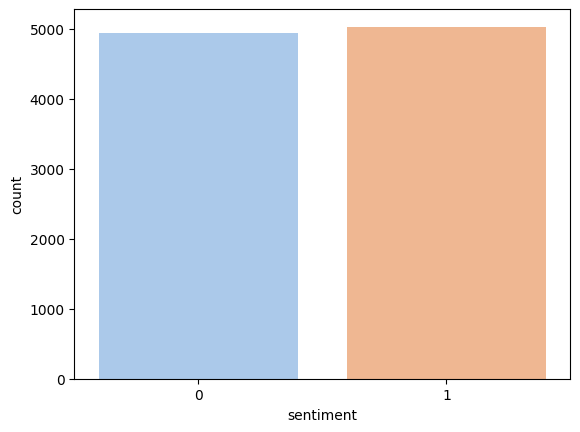

In [6]:
sns.countplot(data = data , x = 'sentiment' , palette = 'pastel')

- There are almost an equal number of positive and negative reviews.
- 
**There is no data imbalance**

# **Semantic Search**

## **Defining the model**

We'll be using the **all-MiniLM-L6-v2** model here.

💡 The **all-MiniLM-L6-v2** model is an all-round (**all**) model trained on a large and diverse dataset of over 1 billion training samples and generates state-of-the-art sentence embeddings of 384 dimensions.

📊  It is a language model (**LM**) that has 6 transformer encoder layers (**L6**) and is a smaller model (**Mini**) trained to mimic the performance of a larger model (BERT).

🛠️ Potential use-cases include text classification, sentiment analysis, and semantic search.

training samples refers to two sentences as a pair and a categorization of similar or not similar 

In [7]:
# defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

- there are many other models to choose from too!
- https://www.sbert.net/docs/pretrained_models.html
- https://huggingface.co/spaces/mteb/leaderboard
- model = SentenceTransformer('BAAI/bge-base-en-v1.5')

## **Basic Examples**

In [8]:
model.encode(['Hello , my name is Sparsh!'])

array([[-7.63789341e-02, -3.46019268e-02,  2.81814318e-02,
         2.60171369e-02, -1.12401642e-01, -6.56800494e-02,
         1.05019473e-01, -4.91613448e-02, -1.32024242e-02,
        -4.02145386e-02, -3.06905396e-02, -6.59567863e-02,
         3.87539491e-02,  2.87568253e-02, -2.82398574e-02,
        -3.12833749e-02,  2.18625460e-02, -1.51858311e-02,
         9.84577555e-03, -9.71754733e-03, -6.44154176e-02,
         5.22475783e-03, -6.68814927e-02, -1.68438535e-02,
        -5.71778938e-02, -5.65784648e-02, -4.20541316e-02,
         8.45702887e-02, -6.76952824e-02, -1.05175219e-01,
         7.60104880e-02,  5.10808453e-03, -2.45320797e-02,
         6.20696992e-02,  4.55954410e-02,  5.43934815e-02,
        -5.97802252e-02,  5.06567257e-03, -3.48678604e-03,
         5.68431877e-02, -3.39885950e-02, -7.81711712e-02,
        -4.98252288e-02, -4.48917113e-02,  3.32635604e-02,
         9.28130001e-02,  2.49645263e-02,  3.81169468e-02,
         9.19575468e-02,  7.75857419e-02, -9.99005437e-0

In [9]:
model.encode(['Hello , my name is Sparsh?'])

array([[-7.44925812e-02, -4.41480204e-02,  3.80302854e-02,
         2.05286909e-02, -1.13463990e-01, -6.95442706e-02,
         1.69507444e-01, -3.63051295e-02, -7.68723851e-03,
        -6.16054721e-02, -2.39743255e-02, -1.05872452e-01,
         3.13828215e-02,  8.78152996e-03, -1.22019164e-02,
        -1.35242119e-02,  2.44078431e-02, -3.13176885e-02,
        -3.17441486e-02, -3.18399630e-02, -1.07249275e-01,
         3.93209746e-03, -5.48754409e-02, -1.78767238e-02,
        -5.17549999e-02, -4.39605005e-02, -2.94698961e-02,
         9.81617793e-02, -4.32574674e-02, -1.03994153e-01,
         7.36738443e-02, -9.25068930e-03, -4.16767172e-04,
         5.53891994e-02,  6.86842725e-02,  6.19356968e-02,
        -4.92506959e-02,  1.02947857e-02, -9.28898063e-03,
         5.86766265e-02, -4.09057960e-02, -8.76082927e-02,
        -4.43565920e-02, -5.69377206e-02,  2.67411396e-02,
         7.51686469e-02,  6.89053116e-03,  3.55312862e-02,
         8.81954208e-02,  5.77825606e-02, -1.05716459e-0

## **Comparing two sentences together**

when we take cosine similarty between two embeddings , that cosine similarity should be high for sentences that are similar and low for sentences that are different

- The L2 norm (Euclidean norm) measures the magnitude (length) of each embedding vector.
- This is necessary for normalization when calculating cosine similarity.
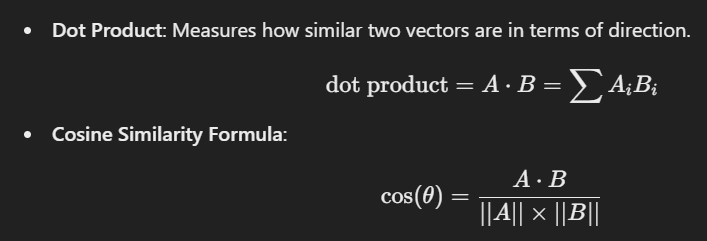

In [10]:
# defining a function to compute the cosine similarity between two embedding vectors
def cosine_score(text):
    # encoding the text
    embeddings = model.encode(text)

    # calculating the L2 norm of the embedding vector
    norm1 = np.linalg.norm(embeddings[0])
    norm2 = np.linalg.norm(embeddings[1])

    # computing the cosine similarity
    cosine_similarity_score = (np.dot(embeddings[0],embeddings[1]))/(norm1 * norm2)
    return cosine_similarity_score

In [11]:
sentence1 = 'The cat is on the mat'
sentence2 = 'The mat has cat on it'
cosine_score([sentence1 , sentence2])

0.9586375

- The **high cosine similarity score** indicates that the sentences are **semantically similar**.

In [12]:
sentence_1 = "Roses are red, violets are blue."
sentence_2 = "The Earth orbits the Sun in our solar system."

cosine_score([sentence_1, sentence_2])

0.1266436

- The **low cosine similarity score** indicates that the sentences are **semantically dissimilar**.

In [13]:
sentence_1 = "My name is Mark and I love football."
sentence_2 = "A strange object was found in the Mariana Trench."

cosine_score([sentence_1, sentence_2])

-0.06156106

### **Encoding the dataset**

In [14]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# encoding the dataset
embedding_matrix = model.encode(data['review'], device = device , show_progress_bar = True)

Batches: 100%|███████████████████████████████████████████████████████████████████████| 312/312 [08:45<00:00,  1.68s/it]


In [16]:
embedding_matrix.shape

(9982, 384)

In [17]:
embedding_matrix[0,:]

array([-7.45214745e-02,  2.59452104e-03, -3.34989615e-02, -4.84161824e-02,
       -3.84774990e-02,  6.37951866e-02,  5.54272998e-03,  4.06937003e-02,
        6.29823580e-02, -3.84879708e-02, -1.27104828e-02, -2.12660544e-02,
        6.79039136e-02,  2.27347692e-03,  1.14879536e-03,  2.30603665e-02,
        8.18004608e-02,  4.14929129e-02, -2.12946460e-02, -2.29654387e-02,
        2.09019836e-02, -2.93924734e-02,  9.37751904e-02, -2.93005202e-02,
       -6.34454042e-02, -1.70642342e-02,  1.12413324e-01, -2.24412587e-02,
       -6.00714013e-02,  1.55951865e-02,  2.08700392e-02,  7.55285248e-02,
       -6.04215041e-02,  2.33690208e-03, -1.79053452e-02,  7.56649598e-02,
        9.78598651e-03,  2.67772209e-02, -1.30182691e-02, -1.76513642e-02,
        3.84344757e-02,  3.93548571e-02,  5.56520447e-02, -1.35075143e-02,
        5.03627807e-02, -7.22083896e-02, -2.37328839e-02, -1.08479746e-01,
        2.67260838e-02, -5.05364873e-02, -8.09638724e-02,  5.58139794e-02,
       -1.44368142e-03, -

### **Querying from the dataset**

**Now, let's search for similar reviews in our dataset.**

In [18]:
# defining a function to find the top k similar sentences for a given query
def top_k_similar_sentences(embedding_matrix , query_text , k):
    # encoding the query text
    query_embedding = model.encode(query_text)

    # calculating the cosine similarity between the query vector and all other encoded vectors of our dataset
    score_vector = np.dot(embedding_matrix , query_embedding)

    # sorting the scores in descending order and choosing the first k
    top_k_indices = np.argsort(score_vector)[::-1][:k]

    # returning the corresponding reviews
    return data.loc[list(top_k_indices) , 'review']

In [19]:
query_text = 'horror movie'

# displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix,query_text,5)

for i in top_k_reviews:
    print(i, end="\n\n")

This completely forgotten slasher flick is one of the best horror movies ever made.Very dark at times it reminds me a little famous thriller "Deliverance".Director Jeff Lieberman creates terrific atmosphere of dread and despair.All actors are decent and the climax is really exciting and memorable.So if you are searching for something creepy,try to find this little treasure.My personal rating:10 out of 10.P.S This one is even more chilling than "Halloween".

I remember watching this film as a kid and I was in complete awe of it, I couldn't take my eyes of the television. This movie has it all for horror fans! This movie had no funny moments expect a couple of one liners by stooge(who was my favorite character in the film) kevin tenney directed this jewel and did a wonderful job with a low budget, I thought the end was awesome the only thing that could stop them was by surviving the night they were unstoppable killing machines! the effects done by steve johnson we're excellent I would re

In [20]:
query_text = 'Indian movie'

# displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix,query_text,5)

for i in top_k_reviews:
    print(i, end="\n\n")

i thought this movie was really really great because, in India cinemas nowadays, all you see is skin, music, and bad acting...in this movie, you can see some tradition, ethnicity, and at least some decency...although some parts were a little dramatic, guess what? that is what Indian cinema is all about! after watching this movie, at least you don't get a headache from all the loud overrated music, or any violence, its just the truth, it teaches about love, and of course caring for the person you love throughout life...i think it was an amazing movie...Kids can watch it without a doubt, and adults will enjoy the simplicity that used to be India's sure profoundness...until all these rap hits, miniskirts, and skin showing became a part of it.

This movie is simply awesome.It was a very sensitive issue and movie was superb.This movie did not create any controversy in India (as far as i know) and its publicity was also kept low.Initially i thought that this movie would simply be a waste of 

In [21]:
query_text = "Action movie with lots of car chases"

# displaying the top 2 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix,query_text,2)

for i in top_k_reviews:
    print(i, end="\n\n")

I think the filmographic lineage may run like this. Pay attention, please, because I had to look this up. In 1967 Peter Yates, an ex auto racer, directs the English caper movie "Robbery," the most thrilling part of which is a car chase through the streets of London, down alleys where there are crowds of children playing and all that. It's a success.<br /><br />A year later, Yates directs "Bullet", starring Steve McCool, I mean McQueen, featuring another even more spectacular car chase up and down the San Francisco Hills, with dumbfoundingly authentic engine sounds that seem to include double clutching, full race cams, no mufflers, twelve-cylinder engines under forty-foot hoods, supercharged, superdupercharged, and all five-thousand horsepower running at full tilt. Lots of shots of McQueen's gum-chewing visage scowling with concentration as he tries to bump another car off the highway, though a passenger in the other vehicle totes a shotgun. The chase is staged by Philip D'Antoni. Bill 

In [22]:
# one highly positive query
query_text = "Overall a great movie that ticks all the right boxes."

# displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix,query_text,3)

for i in top_k_reviews:
    print(i, end="\n\n")

wonderful movie with good story great humour (some great one-liners) and a soundtrack to die for.<br /><br />i've seen it 3 times so far.<br /><br />the american audiences are going to love it.

<br /><br />When I first heard about this back in 1997, over coffee with friends, I decided to check it out. The only problem was that it was on a small screen at one of my local cinema's.<br /><br />That didn't stop the enjoyment of seeing a simply great movie, with a top notch cast in Aidan Quinn, Donald Sutherland, and Ben Kingsley. The whole movie, kept me glued to my seat. <br /><br />I simply found no flaws in this great movie, I give it my highest recommendation to those who love thrillers. I am very proud to have this in my collection.<br /><br />10/10 ( I don't hand this out lightly).

A great film in its genre, the direction, acting, most especially the casting of the film makes it even more powerful. A must see.



In [23]:
# one moderately positive query
query_text = "The movie wasn't great but it delivered as per the expectations."

# displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix,query_text,3)

for i in top_k_reviews:
    print(i, end="\n\n")

This movie turned out to be better than I had expected it to be. Some parts were pretty funny. It was nice to have a movie with a new plot.

I didnt know what to expect . I only watched it on a rainy sunday afternoon on pay tv . Right from the start it drew me in . The music and settings and characters were excellent . I hadnt heard of any of the actors but they all were outstanding . A wonderful thriller .<br /><br />Now that ive read other comments on this movie referring to past versions and the book , i will be endeavouring to find out more on this great movie

Considering the big name cast and lavish production I expected a lot more of this film. The acting for the most part is great, although the story they have to work with is mediocre at best. However the film still warrants watching because of the acting and the stars and some and up and coming young talent.



In [24]:
# one moderately negative query
query_text = "The plot was confusing but the acting performances were okay. The movie was mediocre at best"

# displaying the top 5 similar sentences
top_k_reviews = top_k_similar_sentences(embedding_matrix,query_text,3)

for i in top_k_reviews:
    print(i, end="\n\n")

The plot is tight. The acting is flawless. The directing, script, scenery, casting are all well done. I watch this movie frequently, though I don't know what it is about the whole thing that grabs me. See it and drop me a line if you can figure out why I like it so much.

I read all of the other comments which made this movie out to be an excellent movie. I saw nothing of the excellence that was stated. I thought it was long and boring. I tried twice to watch it. The first time I fell asleep and the second time I made it to within six minutes of the end and gave up. I suppose that it was mainly my fault going in with great expectation, but I don't think that this would have completely ruined the movie for me. The movie was just bland. It had nothing that was spectacular or unique to it. The plot was not half bad, the action sequences were non-existent, the dialogue forced and the movie just went on forever. I would not recommend seeing this movie.

i had gone to the movies expecting to

**Important Note**
1. It is important to note that we loaded a pre-trained model.
2. As the model was not trained or fine-tuned on this data, the performance may not be excellent.
3. As we are doing semantic search and not clustering, there may be reviews that fall in multiple categories.

# **Sentiment Analysis**

In [25]:
X = embedding_matrix
y = data['sentiment']
X_train , X_test , y_train , y_test = train_test_split(X,y , test_size = 0.25 , random_state = 42)

## **1) Random Forest Model**

In [26]:
rf_transformer = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 42)
rf_transformer.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, random_state=42)

In [27]:
# Predicting on train data
y_pred_train = rf_transformer.predict(X_train)

# Predicting on test data
y_pred_test = rf_transformer.predict(X_test)

In [28]:
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = [0, 1]
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

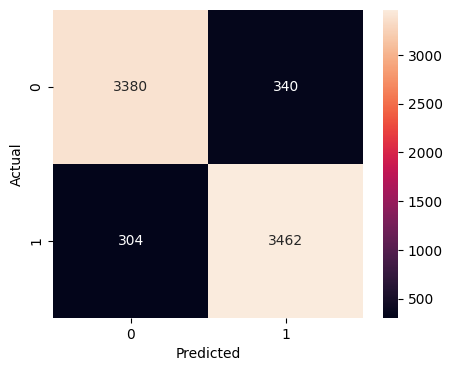

In [29]:
plot_confusion_matrix(y_train , y_pred_train)

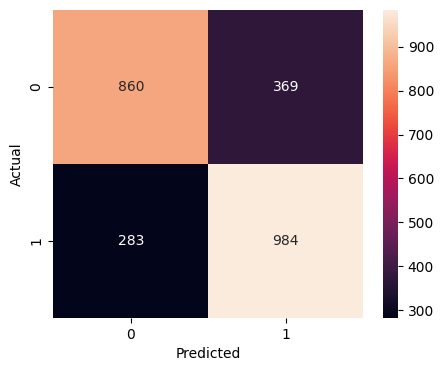

In [30]:
plot_confusion_matrix(y_test , y_pred_test)

### **We can also use pre trained models**

There are some pre trained models on hugging face for sentiment analysis 

There are lots of other models too to perform sentimental analysis 

you can choose to use any other model by including a model argument like:

sentiment_hf = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

or

nlptown/bert-base-multilingual-uncased-sentiment

many more models can be found at https://huggingface.co/models?pipeline_tag=text-classification&sort=trending&search=sentiment

these are all text-classification models...sentiment analysis is a special case of text classification

In [31]:
sentiment_hf = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [32]:
trial_data = ["I love this movie", "This movie is not very good at all!",'There is a cat outside.']
sentiment_hf(trial_data)

[{'label': 'POSITIVE', 'score': 0.9998766183853149},
 {'label': 'NEGATIVE', 'score': 0.9998003840446472},
 {'label': 'NEGATIVE', 'score': 0.6246474385261536}]

In [33]:
hf_review_dict = sentiment_hf(data['review'].to_list() , truncation = True)

In [34]:
hf_review_sent = [0]*len(data['review'])
for movie in range(len(data['review'])):
  if hf_review_dict[movie]['label']=='POSITIVE':
    hf_review_sent[movie] = 1

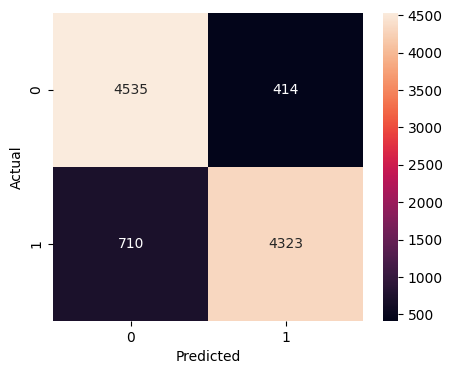

In [35]:
plot_confusion_matrix(y, hf_review_sent)

In [36]:
X = data['review']
y = data["sentiment"]

In [37]:
# initializing a T5 tokenizer using the pre-trained model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
